In [7]:

import pandas
import numpy

import librosa

from matplotlib import pyplot as plt


In [14]:

sr = 4000
window_length = 128
print('window', 1000*window_length/sr)

window 32.0


In [18]:
freq_tolerance_ok = 1.5/100
freq_tolerance_nok = 3.5/100
high_frequencies = [1209, 1336, 1477, 1633]
low_frequencies = [ 697, 770, 852, 941 ]
all_frequencies = low_frequencies + high_frequencies


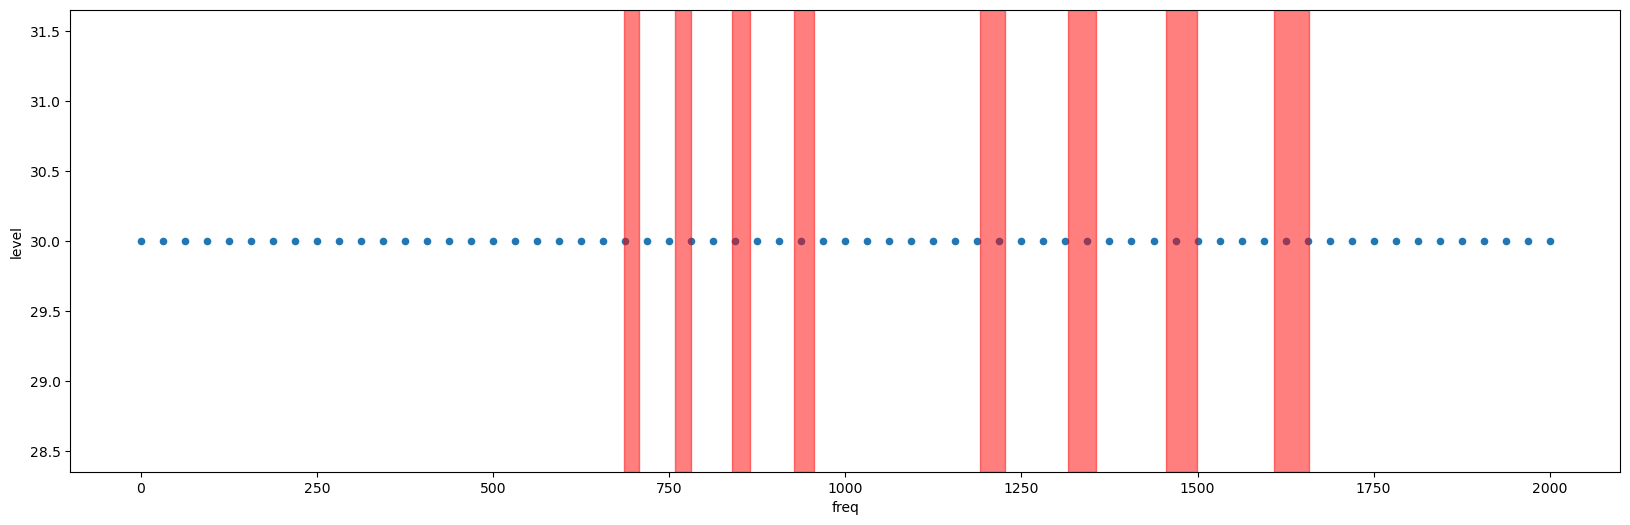

In [26]:
fft_frequencies = librosa.fft_frequencies(sr=sr, n_fft=window_length)
df = pandas.DataFrame({
    'freq': fft_frequencies
})
df['level'] = 30.0
fig, ax = plt.subplots(1, figsize=(20, 6))
df.plot(ax=ax, kind='scatter', x='freq', y='level')

for f in all_frequencies:
    deviation = (f*freq_tolerance_ok)
    f_lower = f - deviation
    f_upper = f + deviation
    ax.axvspan(f_lower, f_upper, alpha=0.5, color='red')


In [62]:
import random

symbols = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '*', '0', '#', 'A', 'B', 'C', 'D']
symbol_frequency_higher = [ 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 3, 3, 3, 43 ]
symbol_frequency_lower = [ 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0, 1, 2, 3 ]
assert len(symbol_frequency_higher) == len(symbols)
assert len(symbol_frequency_lower) == len(symbols)

# Valid and invalid parameters. Ref https://www.britishtelephones.com/dtmf.htm
from dataclasses import dataclass
@dataclass
class SampleParameters():
    freq_deviation_max = 5.0/100
    duration_min = 23/1000.0
    duration_max = 45/1000.0
    pause_min = 8/1000.0
    pause_max = 200/1000.0
    snr_min = 20
    snr_max = 50
    reverse_twist_max = 4.0 # low frequency power is greater than high frequency
    twist_max = 8.0

def sample_dtmf_tone(p):
    uniform = random.uniform
    
    f_deviation_bad = 3.5/100.0

    out = dict(
        symbol_index = random.randint(0, len(symbols)-1),
        snr_lower = uniform(p.snr_min, p.snr_max),
        twist = uniform(-p.reverse_twist_max, p.twist_max),
        f_upper_deviation = uniform(-p.freq_deviation_max, p.freq_deviation_max),
        f_lower_deviation = uniform(-p.freq_deviation_max, p.freq_deviation_max),
        duration = uniform(p.duration_min, p.duration_max),
        pause = uniform(p.pause_min, p.pause_max),
    )

    # FIXME: pick based on symbol
    idx = out['symbol_index']
    f_lower = low_frequencies[symbol_frequency_lower[idx]]
    f_upper = high_frequencies[symbol_frequency_higher[idx]]
    
    out.update(dict(
        f_lower = f_lower + (f_lower * out['f_lower_deviation']),
        f_upper = f_upper + (f_upper * out['f_upper_deviation']),
        snr_upper = out['snr_lower'] + out['twist'],
    ))
    return out
               
def tone_is_valid(t):
    f_deviation_bad = 3.5/100
    twist_bad = 8.0
    reverse_twist_bad = 4.0
    
    f_valid = abs(t.f_upper_deviation) <= f_deviation_bad and \
        abs(t.f_lower_deviation) <= f_deviation_bad

    # FIXME: validate the rest
    valid = f_valid
    return valid

p = SampleParameters()
s = list((sample_dtmf_tone(p) for _ in range(10)))
df = pandas.DataFrame.from_records(s)
df['invalid'] = ~df.apply(tone_is_valid, axis=1)
df

,symbol_index,snr_lower,twist,f_upper_deviation,f_lower_deviation,duration,pause,f_lower,f_upper,snr_upper,invalid
0,9,41.215171,-3.217700,0.018595,-0.021924,0.024867,0.111011,920.369834,1231.481574,37.997471,False
1,7,27.240349,-1.739692,0.042974,-0.032142,0.028544,0.087680,824.614737,1393.412654,25.500658,True
2,9,23.649523,1.320109,0.001890,0.000721,0.034545,0.165806,941.678789,1211.284511,24.969632,False
3,13,27.100987,1.943486,-0.005657,0.038114,0.031989,0.044449,799.347411,1623.762067,29.044473,True
4,9,22.246544,1.506768,0.006689,0.035071,0.042199,0.162756,974.002273,1217.086933,23.753312,True
5,14,42.010722,1.419220,0.037398,-0.012300,0.027324,0.102398,841.520549,1694.071606,43.429942,True
6,10,32.899646,7.284554,0.043421,0.042176,0.023946,0.168710,980.687950,1394.010508,40.184200,True
7,1,42.883251,-3.914159,-0.047662,0.000189,0.028060,0.152047,697.131420,1272.323198,38.969091,True
8,3,42.443137,7.221557,0.003855,0.045292,0.039490,0.141666,804.874538,1213.660728,49.664694,True
9,8,37.508944,6.773171,-0.033182,-0.039375,0.036833,0.010015,818.452342,1427.990263,44.282115,True


(65,) (65,)
(65,) (65,)
(65,) (65,)
(65,) (65,)
(65,) (65,)
(65,) (65,)
(65,) (65,)
(65,) (65,)
(65,) (65,)
(65,) (65,)


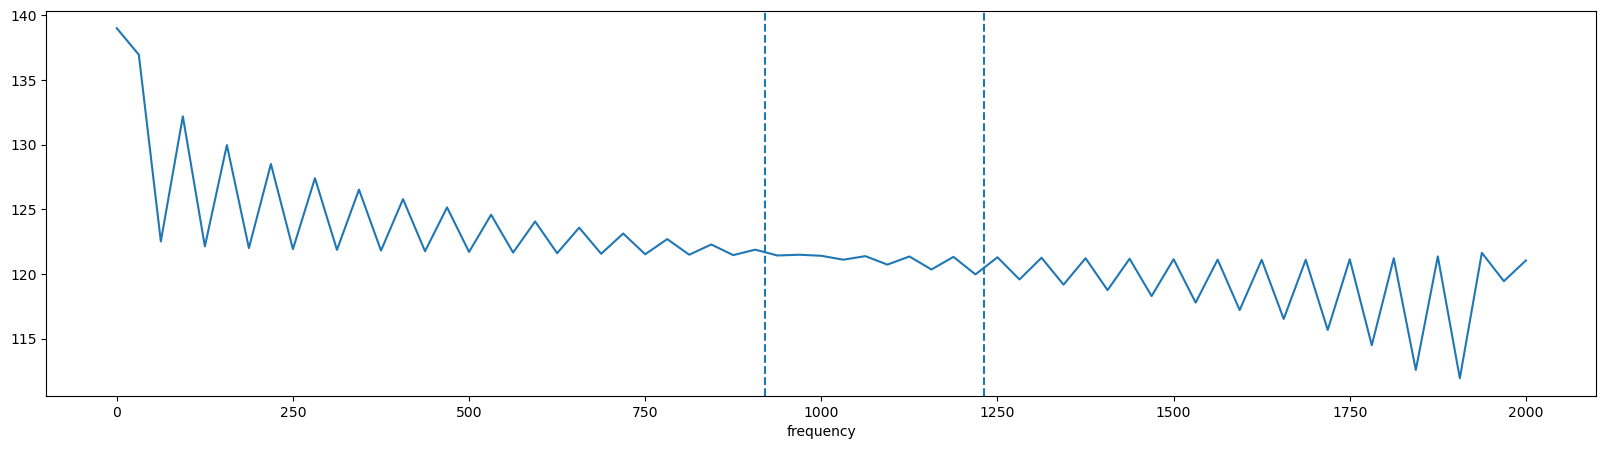

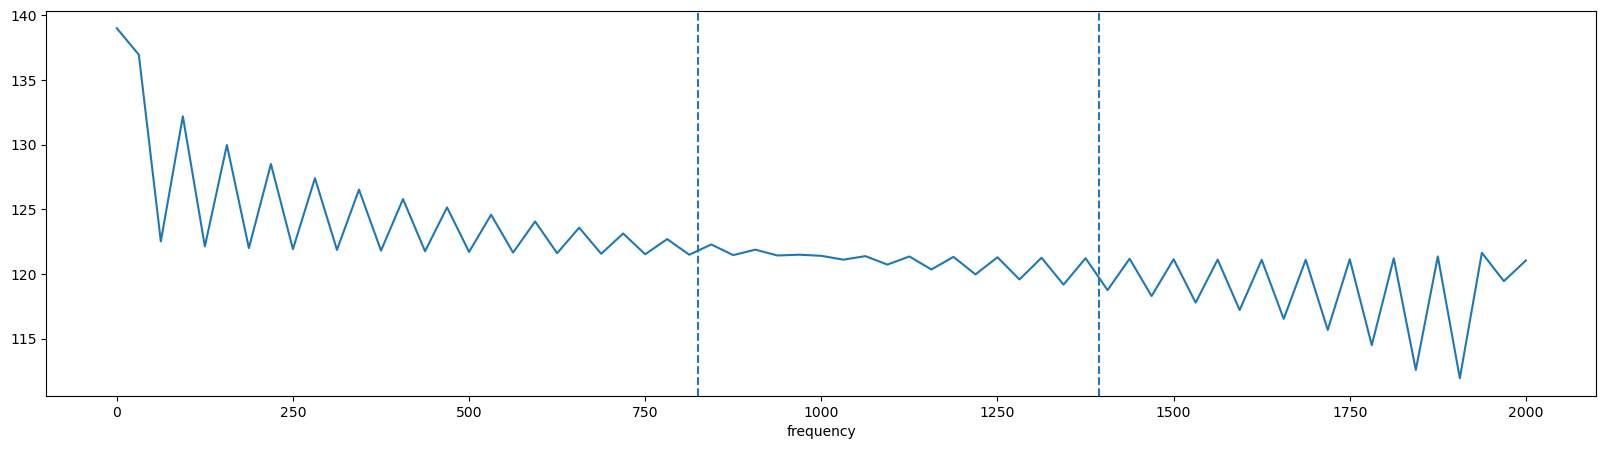

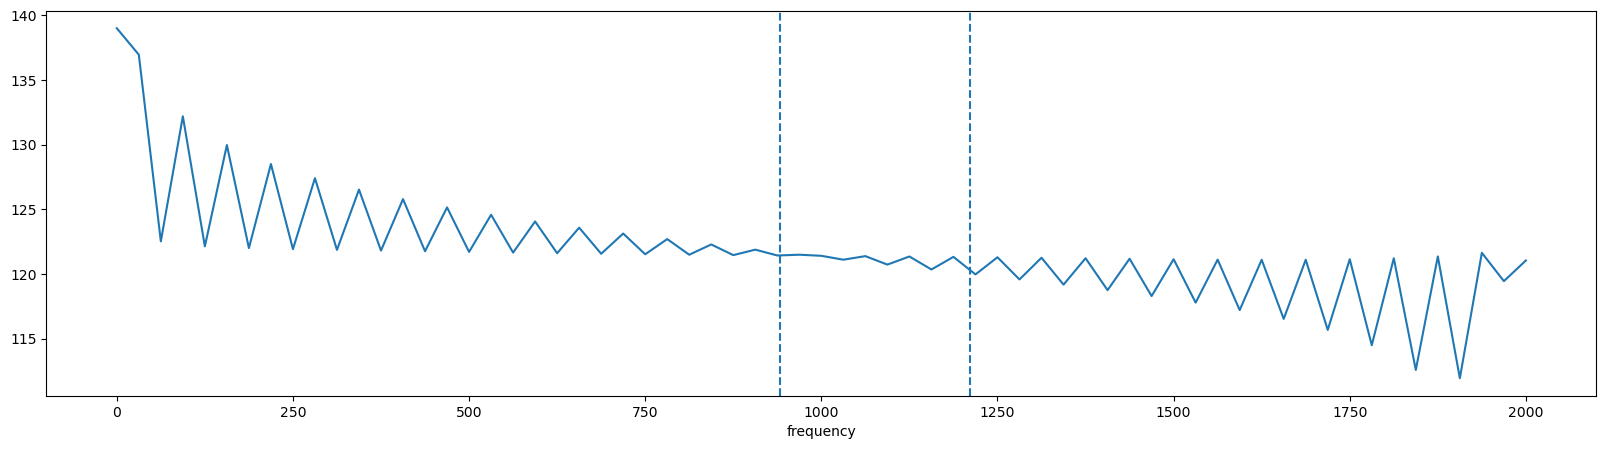

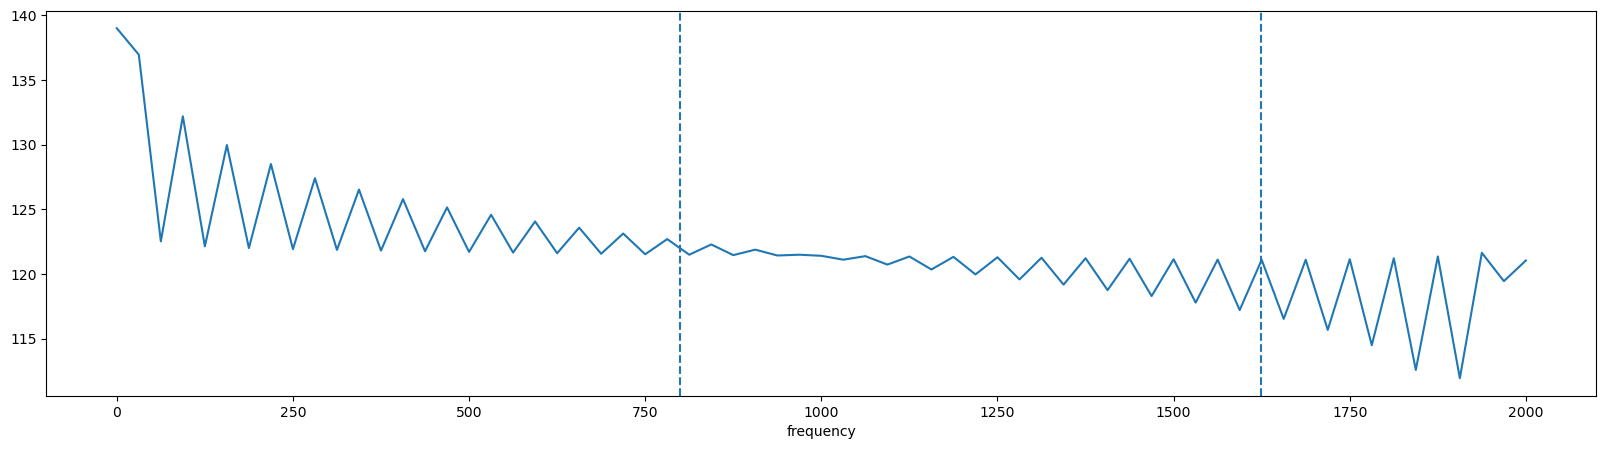

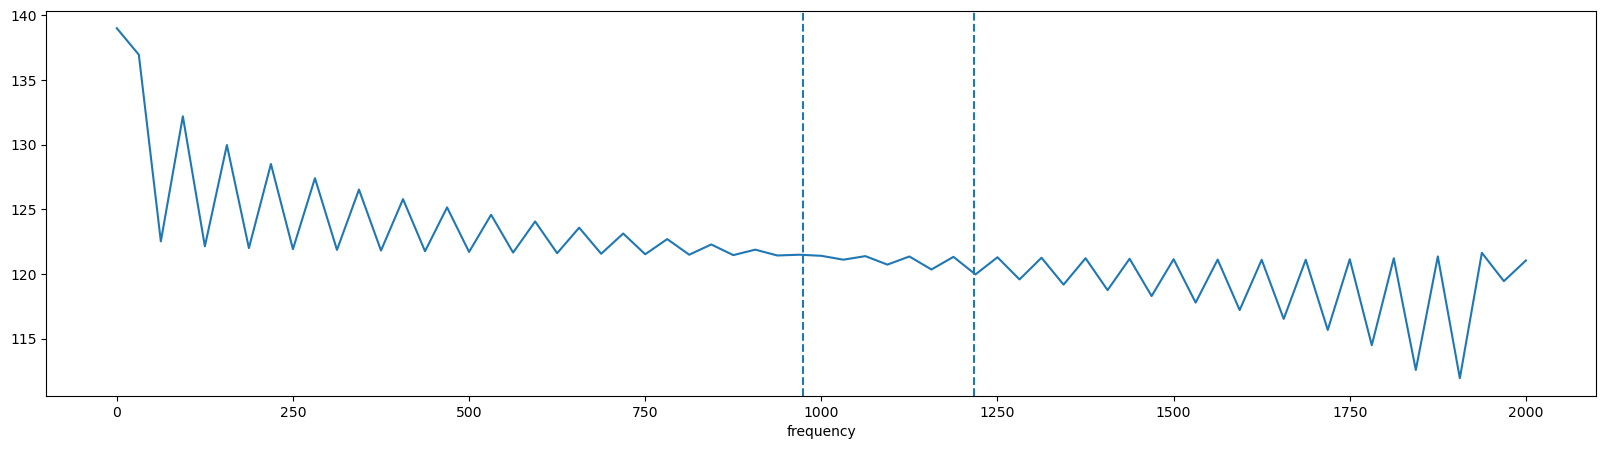

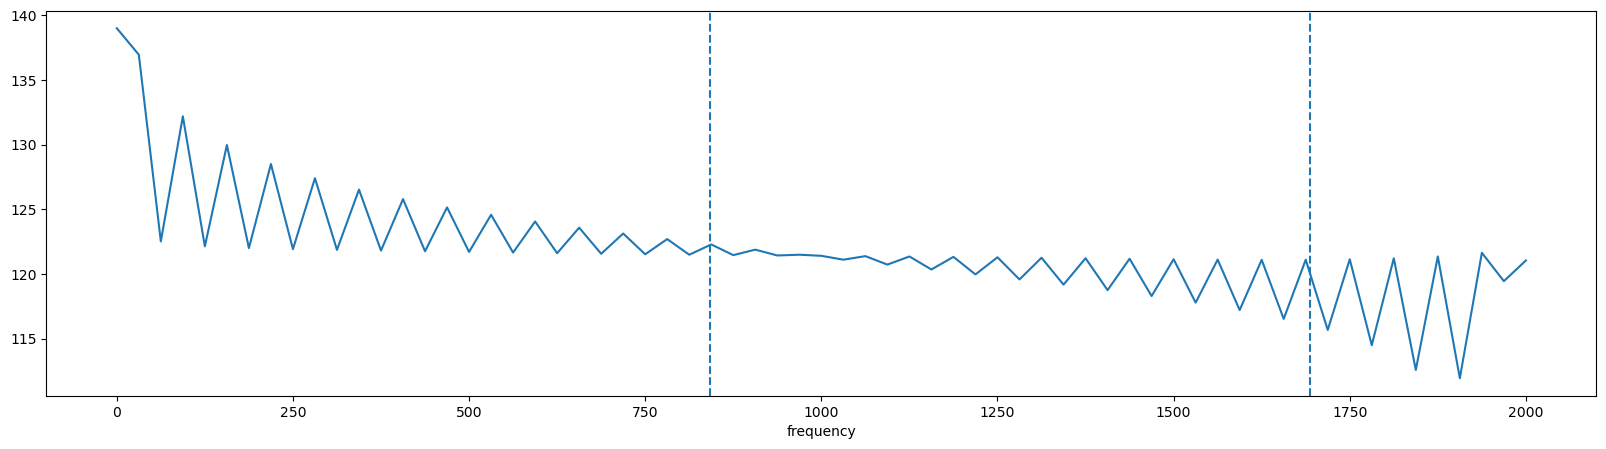

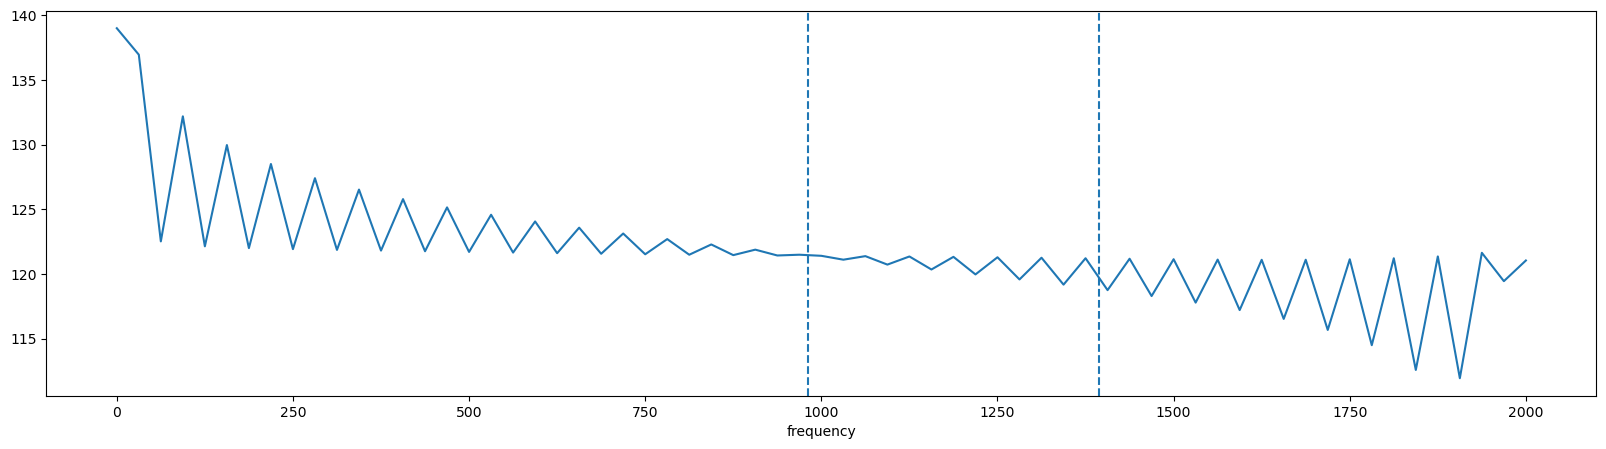

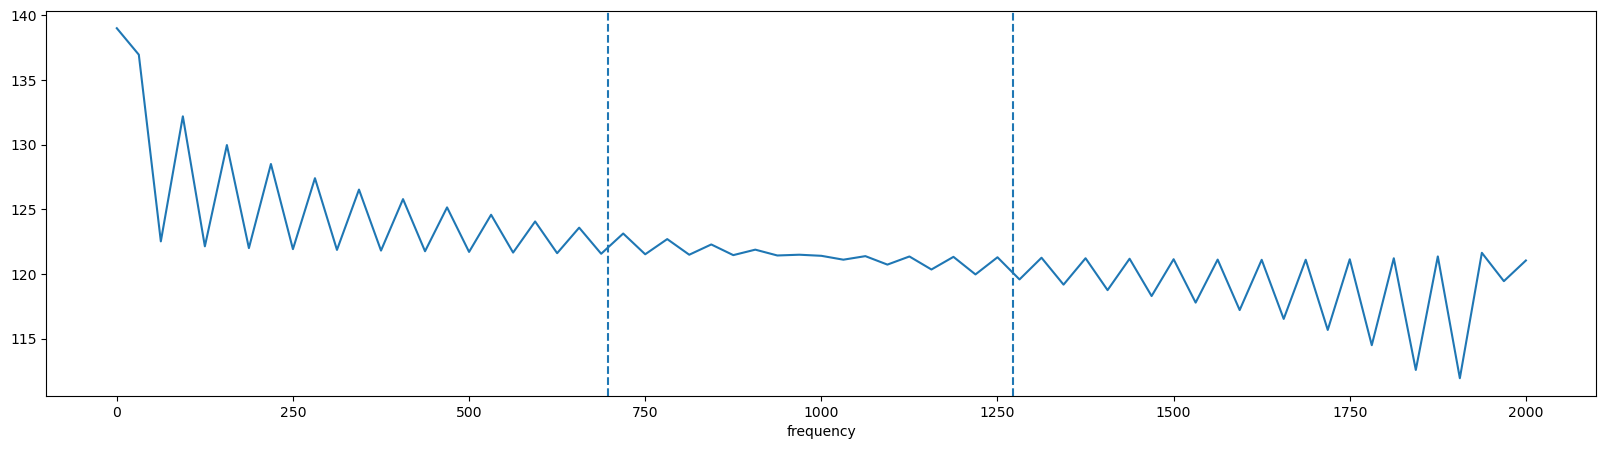

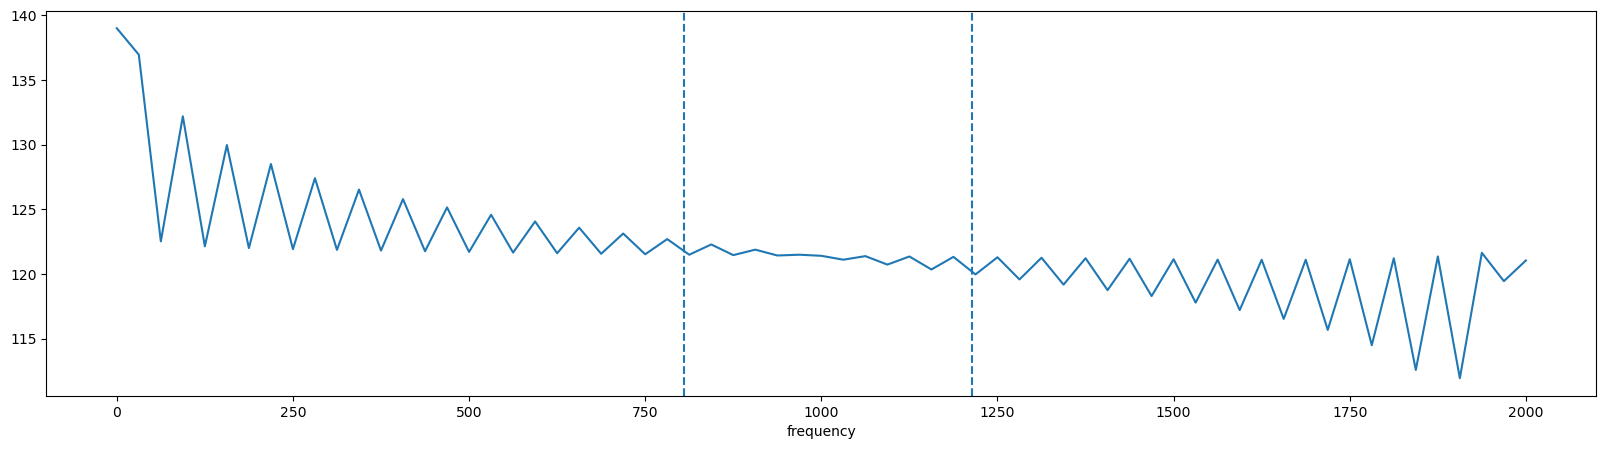

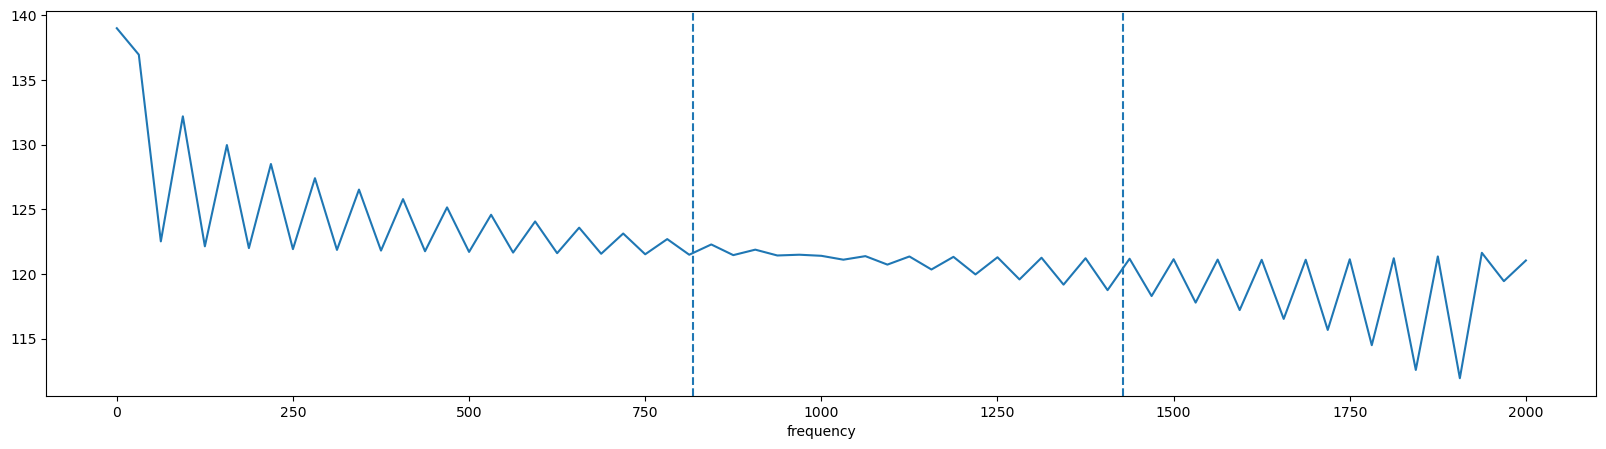

In [93]:

import math
import array

def sinewave(f, amp, dur, sr):
    n = int(dur * sr)
    PI2 = 2 * math.pi
    gen = ((amp*math.sin(PI2*f*t/sr) for t in range(n)))
    return gen

def decibel_to_amplitude(db):
    amplitude = 10**(db/20.0)
    return amplitude
    
def generate_audio(tone, sr):
    lower_f, upper_f = tone['f_lower'], tone['f_upper']
    db_max = 70
    lower_a = decibel_to_amplitude(tone['snr_lower'] - db_max)
    upper_a = decibel_to_amplitude(tone['snr_upper'] - db_max)

    duration = tone['duration']
    sin1 = sinewave(lower_f, lower_a, duration, sr=sr)
    sin2 = sinewave(upper_f, upper_a, duration, sr=sr)
    samples = array.array('f', (s1+s2 for s1, s2 in zip(sin1, sin2)))

    return samples

def spectrum_fft(signal, n_fft, sr):

    f = numpy.fft.fft(signal, n=n_fft)
    power = numpy.abs(f)
    db = librosa.power_to_db(power, ref=0.0, top_db=200)
    #db = db[len(db)//2-1:]
    db = db[:len(db)//2+1]
    freqs = librosa.fft_frequencies(n_fft=n_fft, sr=sr)
    print(db.shape, freqs.shape)
    df = pandas.DataFrame(dict(frequency=freqs, level=db)).set_index('frequency')
    return df['level']

for idx, t in df.iterrows():
    sig = generate_audio(t, sr=sr)
    fig, ax = plt.subplots(1, figsize=(20, 5))
    #ax.plot(sig)
    #ax.set_title(f'f0={t['f_lower']} f1={t['f_upper']}')
    #librosa.display.waveshow(y=numpy.array(sig), ax=ax, sr=sr)
    #print(s)
    s = spectrum_fft(s, 128, sr=sr)
    s.plot(x='frequency', y='level', ax=ax)
    ax.axvline(t['f_lower'], ls='--')
    ax.axvline(t['f_upper'], ls='--')

# FFT of audio
